In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from typing import List ,Dict, Tuple
import numpy as np

In [80]:
train = pd.read_csv('./JobCare_data/train.csv')

In [81]:
nominal_cols = ['person_attribute_a_1','person_attribute_b','person_prefer_e','contents_attribute_e']

In [ ]:
# 오버피팅이 자주 발생하는 mean encoding 이므로 cross validation 과 정규화 같이 사용한다=
# 변환 하고자 하는 범주형 변수 선택
# 범주형 변수 그룹화 -> 타깃 변수 총합 합계
# 범주형 변수 그룹화 타깃 빈도수 합계
# 총합을 카운트로 나누고 본래 범주 값에 업데이트
# 여러가지 방법으로 적용 가능하다
# 비슷한 범주 사이에 있는 관계 표현 특징, 범주와 타깃사이에만 국한된다
# 범주가 많은 경우 이 방법은 데이터를 훨씬 더 단순화 한다

In [82]:
for col in nominal_cols:
    if 'attribute' in col:
        name = col[col.index('attribute') + len('attribute')+1:]
        var_name = 'attr_{}_mean_encode'.format(name)
        locals()[var_name] = train.groupby(col)["target"].mean()
    elif 'prefer' in col:
        name = col[col.index('prefer') + len('prefer')+1:]
        var_name = 'prefer_{}_mean_encode'.format(name)
        locals()[var_name] = train.groupby(col)["target"].mean()
    train.loc[:,var_name] = train[col].map(locals()[var_name])

In [83]:
target = train.target
train = train.drop('target',axis=1)

In [84]:
train = train.drop(['contents_open_dt','id'],axis=1)

In [85]:
train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
0,True,True,True,False,False,False,1,4,3,5,...,275,1,4,139,618822,354805,0.483610,0.487071,0.580604,0.504105
1,False,False,False,True,True,False,1,3,4,1,...,275,1,4,133,571659,346213,0.486858,0.500850,0.500543,0.504105
2,False,False,False,True,False,False,2,0,3,5,...,94,1,4,53,399816,206408,0.493002,0.487071,0.479206,0.504105
3,False,False,False,True,False,False,2,0,2,5,...,275,5,3,74,827967,572323,0.493002,0.503328,0.479206,0.498611
4,True,True,True,False,False,False,1,3,4,5,...,275,1,4,74,831614,573899,0.486858,0.500850,0.500543,0.504105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,...,147,1,5,65,503156,285850,0.497688,0.503328,0.479206,0.506072
501947,True,True,False,True,False,False,1,6,2,1,...,120,1,4,142,676255,456996,0.515074,0.503328,0.500543,0.504105
501948,True,True,True,True,False,False,1,7,4,1,...,147,2,7,65,484528,293258,0.565771,0.500850,0.500543,0.528446
501949,True,False,False,True,False,False,1,1,2,1,...,147,3,4,259,456330,273797,0.497688,0.503328,0.500543,0.504105


In [111]:
x_train, x_valid, y_train, y_valid = train_test_split(train,target , test_size=0.3 , shuffle=True, stratify=target, random_state=34)
# gradient boosting 이 randomforest 보다 좋다고 알려져있다
rf= RandomForestClassifier(n_estimators=150 , max_depth=8 , min_samples_split=4, max_features=0.2, n_jobs=-1 ,random_state=0)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=8, max_features=0.2, min_samples_split=4,
                       n_estimators=150, n_jobs=-1, random_state=0)

In [86]:
from sklearn.metrics import log_loss
import lightgbm as lgbm

In [92]:
from optuna import trial
from optuna.integration import LightGBMPruningCallback

In [103]:
from optuna.trial import Trial

In [138]:
def objective(trial,X,y):
    param_grid = {
        # "device_type" : trial.suggest_categorical("device_type",['gpu']),
        "learning_rate" : trial.suggest_float("learning_rate", 0.1, 0.95, step=0.1 ),
        "num_leaves" : trial.suggest_int("num_leaves", 5, 100 ,step=5),
        "max_depth" : trial.suggest_int("max_depth", 1,30 , step=3),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf" ,50 , 1000 , step=50),
        "lambda_l1" : trial.suggest_int("lambda_l1", 0,100 , step=5),
        "lambda_l2" : trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split" : trial.suggest_float("min_datin_to_split" , 1,30, step=3),
        "bagging_fraction" : trial.suggest_float("bagging_fraction" , 0.1,0.99,step=0.1),
        "bagging_freq" : trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction" : trial.suggest_float("feature_fraction", 0.1,0.99,step=0.1),
        "n_estimators" : trial.suggest_int("n_estimators",10,2000, step=10),
    }
    cv=  StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)


    for idx, (train_idx, test_idx ) in enumerate(cv.split(X,y)):
        print(X,train_idx)
        X_train , X_test = X.iloc[train_idx] , X.iloc[test_idx]
        y_train , y_test = y[train_idx] , y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary" , **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            eval_metric = "binary_logloss",
            early_stopping_rounds =100,
            callbacks= [
                LightGBMPruningCallback(trial, "binary_logloss")
            ], # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test,preds)

    #return np.mean(f1_scores)
    return np.mean(cv_scores)

In [ ]:
# mean encode값 랜포보다 성능좋다고 알려진 Lightgbm에 넣기
import numpy as np
import optuna
import lightgbm as lgbm
study = optuna.create_study(direction="minimize" , study_name = "LGBM Classifier")
func = lambda trial: objective(trial,train,target )
study.optimize(func,n_trials=20)

[I 2021-12-29 23:21:16,760] A new study created in memory with name: LGBM Classifier
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/distributions.py:54

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=850
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False    

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=850
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=850
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=850
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=850
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=16.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=16.0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False    

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=16.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=16.0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=16.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=16.0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=16.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=16.0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=16.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=16.0
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=4.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1       

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=4.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=4.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=4.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value i

        d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  \
0               True          True          True         False         False   
1              False         False         False          True          True   
2              False         False         False          True         False   
3              False         False         False          True         False   
4               True          True          True         False         False   
...              ...           ...           ...           ...           ...   
501946         False         False         False          True         False   
501947          True          True         False          True         False   
501948          True          True          True          True         False   
501949          True         False         False          True         False   
501950          True          True          True          True         False   

        h_s_match_yn  person_attribute_

/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
Trial.suggest_float(name="learning_rate",low= 0.1 ,high=0.95, step=0.1 )

In [109]:
trial.suggest_float(name="learning_rate",low= 0.1 ,high=0.95, step=0.1 )

TypeError: suggest_float() missing 1 required positional argument: 'self'

In [111]:
trial = Trial()

TypeError: __init__() missing 2 required positional arguments: 'study' and 'trial_id'

In [112]:
# trial suggest_float 메서드는 self 가 필요한데 이렇게 익명함수 명을 함수명으로 해서 다른 함수의 인자로 넘기면 가능한가 ?
lambda trial : objective(trial,X,y)

<function __main__.<lambda>(trial)>

In [113]:
target

0         1
1         0
2         0
3         0
4         0
         ..
501946    1
501947    1
501948    1
501949    1
501950    1
Name: target, Length: 501951, dtype: int64

In [115]:
train = train.drop(['person_rn','contents_rn'], axis=1)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
0,True,True,True,False,False,False,1,4,3,5,...,2,1608,275,1,4,139,0.483610,0.487071,0.580604,0.504105
1,False,False,False,True,True,False,1,3,4,1,...,2,1608,275,1,4,133,0.486858,0.500850,0.500543,0.504105
2,False,False,False,True,False,False,2,0,3,5,...,1,1600,94,1,4,53,0.493002,0.487071,0.479206,0.504105
3,False,False,False,True,False,False,2,0,2,5,...,2,1608,275,5,3,74,0.493002,0.503328,0.479206,0.498611
4,True,True,True,False,False,False,1,3,4,5,...,2,1608,275,1,4,74,0.486858,0.500850,0.500543,0.504105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,...,2,354,147,1,5,65,0.497688,0.503328,0.479206,0.506072
501947,True,True,False,True,False,False,1,6,2,1,...,2,163,120,1,4,142,0.515074,0.503328,0.500543,0.504105
501948,True,True,True,True,False,False,1,7,4,1,...,2,438,147,2,7,65,0.565771,0.500850,0.500543,0.528446
501949,True,False,False,True,False,False,1,1,2,1,...,2,660,147,3,4,259,0.497688,0.503328,0.500543,0.504105


In [ ]:
param_grid = {
        # "device_type" : trial.suggest_categorical("device_type",['gpu']),
        "learning_rate" : trial.suggest_float(name="learning_rate",low= 0.1 ,high=0.95, step=0.1 ),
        "num_leaves" : trial.suggest_float("num_leaves", 5, 100 ,step=5),
        "max_depth" : trial.suggest_int("max_depth", 1,30 , step=3),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf" ,50 , 1000 , step=50),
        "lambda_l1" : trial.suggest_int("lambda_l1", 0,100 , step=5),
        "lambda_l2" : trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split" : trial.suggest_float("min_datin_to_split" , 1,30, step=3),
        "bagging_fraction" : trial.suggest_float("bagging_fraction" , 0,1,0.99,step-0.1),
        "bagging_freq" : trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction" : trial.suggest_float("feature_fraction", 0,1,0.99,step=0.1),
        "n_estimators" : trial.suggest_int("n_estimators",10,2000, step=10),
    }

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [ ]:
# 과적합일진 모르지만 그래도많이올랐따 만족할 수 없음
# 0.57정도에서 0.59 정도로 mean encoding 으로 상승 -> 랜포말고 다른건 ?
(y_valid == rf.predict(x_valid)).mean()

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

#define dataset

,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
365932,0.496387,0.500850,0.512256,0.504105
177697,0.497688,0.487071,0.488677,0.506072
239982,0.496387,0.487071,0.531888,0.498611
245311,0.496387,0.500850,0.479206,0.504105
298685,0.493002,0.503328,0.479206,0.504105
...,...,...,...,...
106445,0.496374,0.503328,0.512256,0.506072
80293,0.496374,0.503328,0.512256,0.504105
475326,0.486858,0.503328,0.479206,0.498611
114645,0.497688,0.503328,0.500543,0.504105


In [90]:
y = y_train.values.tolist()

In [ ]:
X, y = make_regression(n_samples=1000, n_features=10 , n_informative=5, random_state=1)
#evaluate the model

In [92]:
model = CatBoostRegressor(verbose=0 , n_estimators=100)
cv = RepeatedKFold(n_splits= 10 , n_repeats=3 , random_state=1)
n_scores = cross_val_score(model, X,y , scoring='neg_mean_absolute_error', cv=cv)
print('MAE : %.3f (%.3f)'  % (mean(n_scores), std(n_scores)))
#fit the model on the whole dataset
model = CatBoostRegressor(verbose=0 , n_estimators=100)
model.fit(X,y)
# make a single prediction

MAE : -0.494 (0.000)


In [93]:
row = x_valid[[col for col in x_train.columns if 'mean_encode' in col]].values.tolist()

In [94]:
#row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
# make a single prediction
yhat = model.predict(row)
print('Prediction: %.3f' % yhat[0])

Prediction: 0.524


[[0.48360970107163,
  0.5033276160869021,
  0.5005434103685197,
  0.5041052679527183],
 [0.4930024081802479,
  0.5008498349834983,
  0.47920648897861584,
  0.5041052679527183],
 [0.48360970107163,
  0.5033276160869021,
  0.5005434103685197,
  0.5041052679527183],
 [0.4930024081802479,
  0.5033276160869021,
  0.5005434103685197,
  0.5060721805984036],
 [0.4930024081802479,
  0.48707066507036395,
  0.48867658527806107,
  0.49861135543437124],
 [0.4976877195849334,
  0.5033276160869021,
  0.5005434103685197,
  0.5102246543778802],
 [0.5657709512935214,
  0.5033276160869021,
  0.5005434103685197,
  0.49861135543437124],
 [0.49637436616305836,
  0.5033276160869021,
  0.5005434103685197,
  0.5041052679527183],
 [0.48685800604229607,
  0.48707066507036395,
  0.5005434103685197,
  0.5060721805984036],
 [0.49638693515752963,
  0.5008498349834983,
  0.5005434103685197,
  0.49861135543437124],
 [0.5150742673625051,
  0.5033276160869021,
  0.5005434103685197,
  0.49861135543437124],
 [0.4836097010

In [98]:
(yhat == y_valid.values.tolist()).mean()

0.0

In [ ]:
x_train.columns

In [ ]:
#catboost + cv 5fold + threshold

In [1]:
# 전역 변수
SEED = 42
DATA_PATH = './JobCare_data/'

In [4]:
train_data = pd.read_csv(f'{DATA_PATH}train.csv')
test_data = pd.read_csv(f'{DATA_PATH}test.csv')

In [5]:
code_d = pd.read_csv(f'{DATA_PATH}속성_D_코드.csv').iloc[:,:-1]
code_h = pd.read_csv(f'{DATA_PATH}속성_H_코드.csv')
code_l = pd.read_csv(f'{DATA_PATH}속성_L_코드.csv')

In [11]:
train_data.drop(['id','contents_open_dt'],axis=1)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target
0,True,True,True,False,False,False,1,4,3,5,...,1,2,1608,275,1,4,139,618822,354805,1
1,False,False,False,True,True,False,1,3,4,1,...,1,2,1608,275,1,4,133,571659,346213,0
2,False,False,False,True,False,False,2,0,3,5,...,1,1,1600,94,1,4,53,399816,206408,0
3,False,False,False,True,False,False,2,0,2,5,...,1,2,1608,275,5,3,74,827967,572323,0
4,True,True,True,False,False,False,1,3,4,5,...,1,2,1608,275,1,4,74,831614,573899,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,...,1,2,354,147,1,5,65,503156,285850,1
501947,True,True,False,True,False,False,1,6,2,1,...,1,2,163,120,1,4,142,676255,456996,1
501948,True,True,True,True,False,False,1,7,4,1,...,1,2,438,147,2,7,65,484528,293258,1
501949,True,False,False,True,False,False,1,1,2,1,...,1,2,660,147,3,4,259,456330,273797,1


In [12]:
train_data.drop(['contents_rn','person_rn'],axis=1)

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1,2,1608,275,1,4,139,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,1,1,2,1608,275,1,4,133,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,2,1,1,1600,94,1,4,53,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,1,1,2,1608,275,5,3,74,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1,2,1608,275,1,4,74,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,1,1,2,354,147,1,5,65,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,1,2,163,120,1,4,142,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,1,1,2,438,147,2,7,65,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,1,1,2,660,147,3,4,259,2020-06-15 09:23:21,1


In [13]:
train_data.drop(['contents_open_dt'],axis=1)

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target
0,0,True,True,True,False,False,False,1,4,3,...,1,2,1608,275,1,4,139,618822,354805,1
1,1,False,False,False,True,True,False,1,3,4,...,1,2,1608,275,1,4,133,571659,346213,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1,1600,94,1,4,53,399816,206408,0
3,3,False,False,False,True,False,False,2,0,2,...,1,2,1608,275,5,3,74,827967,572323,0
4,4,True,True,True,False,False,False,1,3,4,...,1,2,1608,275,1,4,74,831614,573899,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,1,2,354,147,1,5,65,503156,285850,1
501947,501947,True,True,False,True,False,False,1,6,2,...,1,2,163,120,1,4,142,676255,456996,1
501948,501948,True,True,True,True,False,False,1,7,4,...,1,2,438,147,2,7,65,484528,293258,1
501949,501949,True,False,False,True,False,False,1,1,2,...,1,2,660,147,3,4,259,456330,273797,1


In [ ]:
train_data

In [ ]:
#%
#Backward difference 코딩에서
# #수준에 대한 종속 변수의 평균은 이전 수준에 대한 종속 변수의 평균과 비교됩니다. 이러한 유형의 코딩은 명목 또는 순서 변수에 유용할 수 있습니다.'
#In backward difference coding,
# the mean of the dependent variable for a level is
# compared with the mean of the dependent variable for the prior level.
# This type of coding may be useful for a nominal or an ordinal variable.'

In [14]:
train_data

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [ ]:
code_d.columns  = ["attribute_d", "attribute_d_d" , "attribute_d_s", "attribute_d_m" , "attribute_d_l"]
code_h.columns = ["attribute_h" , "attribute_h_p"]
code_l.columns = ["attribute_l", "attribute_l_d", "attribute_l_s" , "attribute_l_m", "attribute_l_l"]

In [26]:
ordinal_cols = ['person_attribute_a_1','person_attribute_b', 'person_prefer_e', 'contents_attribute_e']

In [ ]:
cols = train_data.columns

In [45]:
temp =[]
def get_meta_data(cols):
    binary_col = []
    nominal_col = []
    ordinal_col = []
    for col in cols:
        if 'yn' in col:
            temp.append((col,'binary'))
        elif col in ordinal_cols:
            temp.append((col,'ordinal'))
        else:
            temp.append((col,'nominal'))
    return temp

In [46]:
data = get_meta_data(cols)

In [47]:
meta_data = pd.DataFrame(data)

In [48]:
meta_data.columns = ['col_name', 'type']

In [49]:
meta_data

,col_name,type
0,id,nominal
1,d_l_match_yn,binary
2,d_m_match_yn,binary
3,d_s_match_yn,binary
4,h_l_match_yn,binary
5,h_m_match_yn,binary
6,h_s_match_yn,binary
7,person_attribute_a,nominal
8,person_attribute_a_1,ordinal
9,person_attribute_b,ordinal


In [ ]:
meta_data = pd.DataFrame(columns=['col_name','type'])

In [36]:
meta_data

,col_name,type


In [50]:
train_data

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [51]:
train_data.value_counts()

id      d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  h_m_match_yn  h_s_match_yn  person_attribute_a  person_attribute_a_1  person_attribute_b  person_prefer_c  person_prefer_d_1  person_prefer_d_2  person_prefer_d_3  person_prefer_e  person_prefer_f  person_prefer_g  person_prefer_h_1  person_prefer_h_2  person_prefer_h_3  contents_attribute_i  contents_attribute_a  contents_attribute_j_1  contents_attribute_j  contents_attribute_c  contents_attribute_k  contents_attribute_l  contents_attribute_d  contents_attribute_m  contents_attribute_e  contents_attribute_h  person_rn  contents_rn  contents_open_dt     target
0       True          True          True          False         False         False         1                   4                     3                   5                275                370                369                8                1                1                4                  95                 59                 3                     3         

In [55]:
train_data[ordinal_cols].value_counts()

person_attribute_a_1  person_attribute_b  person_prefer_e  contents_attribute_e
0                     2                   3                3                       14938
                      3                   3                3                        9443
                      2                   4                4                        8354
                                                           3                        8155
                                          3                4                        8054
                                                                                   ...  
6                     5                   7                8                           1
5                     5                   6                9                           1
6                     5                   8                2                           1
5                     5                   6                8                           1
                      1       

In [57]:
import seaborn as sns

In [63]:
ordinal_cols[0]

'person_attribute_a_1'

In [ ]:
train_data['target']

0    158626
1     61195
5     57783
2     51895
6     49820
3     46340
4     44325
7     31967
Name: person_attribute_a_1, dtype: int64
2    223884
3    139489
4    121200
1     10150
5      7123
0       105
Name: person_attribute_b, dtype: int64
4     160100
3     139683
5      81635
0      66676
6      31407
7       8641
8       6259
2       2323
10      1936
9       1473
11      1452
1        366
Name: person_prefer_e, dtype: int64
3     187593
4     175628
5      81684
6      27776
2       9414
7       7734
1       5179
8       3991
0       1025
9        908
10       673
11       346
Name: contents_attribute_e, dtype: int64


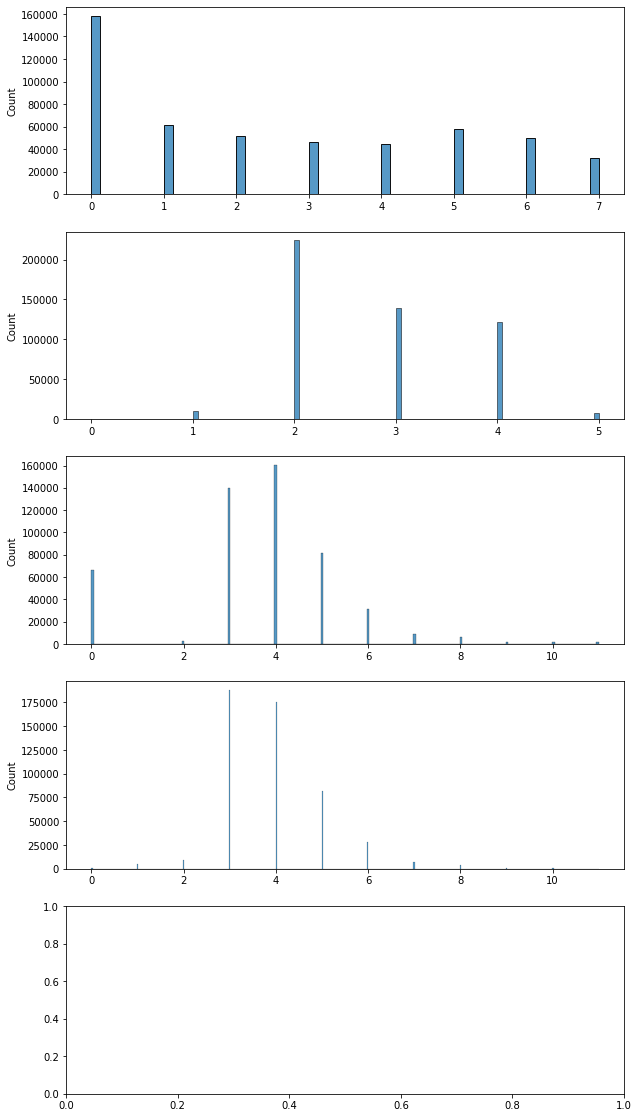

In [76]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5,1,figsize=(10,20))
for i in range(len(ordinal_cols)):
    print(train_data[ordinal_cols[i]].value_counts())
    sns.histplot(train_data[ordinal_cols[i]].values ,ax=ax[i])

In [49]:
code_d.add_prefix("contents_attribute_e_")

,contents_attribute_e_attribute_d,contents_attribute_e_attribute_d_d,contents_attribute_e_attribute_d_s,contents_attribute_e_attribute_d_m,contents_attribute_e_attribute_d_l
0,4,4,2,3,1
1,5,5,2,3,1
2,7,7,2,6,1
3,8,8,2,6,1
4,9,8,2,6,1
...,...,...,...,...,...
1109,1254,1254,1235,1254,1235
1110,1255,1254,1235,1254,1235
1111,1256,1254,1235,1254,1235
1112,1257,1254,1235,1254,1235


,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [ ]:
train_data

In [54]:
# 하나는 있는 거니까 , left merge는 있는 컬럼키면 그대로두고
# 없는 컬럼 키면 그대로 붙이니까 merge가 가능하다

In [56]:
def merge_codes(df:pd.DataFrame, df_code:pd.DataFrame, col:str) -> pd.DataFrame:
    df = df.copy()
    df_code = df_code.copy()
    df_code = df_code.add_prefix(f"{col}_")
    # join key 설정
    df_code.columns.values[0] = col
    print('df :' ,df)
    print('df_code : ', df_code)
    print('merge data : ',pd.merge(df,df_code , how='left', on= col) )
    return pd.merge(df,df_code , how='left', on= col)

typing.List[typing.Tuple[str, pandas.core.frame.DataFrame]]

In [ ]:
List[Tuple[str,pd.DataFrame]]

In [52]:
# type hinting , type annotation 타입에 대한 메타 정보를 제공한다 중대규모 이상프로젝트에서는 컴파일 위험 에러
def preprocess_data(
                    df:pd.DataFrame,is_train:bool = True,
                    cols_merge:List[Tuple[str,pd.DataFrame]] = []  ,
                    cols_equi:List[Tuple[str,str]]= [] ,
                    cols_drop:List[str] = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt"]
                    )->Tuple[pd.DataFrame,np.ndarray]:

    y_data = None

    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    for col , df_code in cols_merge:
        df = merge_codes(df, df_code, col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2]).astype(int)
    df = df.drop(columns=cols_drop)

    return (df,y_data)

,attribute_d,attribute_d_d,attribute_d_s,attribute_d_m,attribute_d_l
0,4,4,2,3,1
1,5,5,2,3,1
2,7,7,2,6,1
3,8,8,2,6,1
4,9,8,2,6,1
...,...,...,...,...,...
1109,1254,1254,1235,1254,1235
1110,1255,1254,1235,1254,1235
1111,1256,1254,1235,1254,1235
1112,1257,1254,1235,1254,1235


In [ ]:
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
]

In [27]:

# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [
    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),
    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_h_1_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_2_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_3_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
]

# 학습에 필요없는 컬럼 리스트
cols_drop = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt", "contents_rn", ]

In [116]:
x_train, y_train = preprocess_data(train_data, cols_merge = cols_merge , cols_equi= cols_equi , cols_drop = cols_drop)
x_test, _ = preprocess_data(test_data,is_train = False, cols_merge = cols_merge , cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape

df :             id  d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  \
0            0          True          True          True         False   
1            1         False         False         False          True   
2            2         False         False         False          True   
3            3         False         False         False          True   
4            4          True          True          True         False   
...        ...           ...           ...           ...           ...   
501946  501946         False         False         False          True   
501947  501947          True          True         False          True   
501948  501948          True          True          True          True   
501949  501949          True         False         False          True   
501950  501950          True          True          True          True   

        h_m_match_yn  h_s_match_yn  person_attribute_a  person_attribute_a_1  \
0              False      

((501951, 64), (501951,), (46404, 64))

,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
365932,0.496387,0.500850,0.512256,0.504105
177697,0.497688,0.487071,0.488677,0.506072
239982,0.496387,0.487071,0.531888,0.498611
245311,0.496387,0.500850,0.479206,0.504105
298685,0.493002,0.503328,0.479206,0.504105
...,...,...,...,...
106445,0.496374,0.503328,0.512256,0.506072
80293,0.496374,0.503328,0.512256,0.504105
475326,0.486858,0.503328,0.479206,0.498611
114645,0.497688,0.503328,0.500543,0.504105


In [124]:
x_train  = x_train.iloc[:351365,:]

In [125]:
y_train = y_train[:351365]

,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
365932,0.496387,0.500850,0.512256,0.504105
177697,0.497688,0.487071,0.488677,0.506072
239982,0.496387,0.487071,0.531888,0.498611
245311,0.496387,0.500850,0.479206,0.504105
298685,0.493002,0.503328,0.479206,0.504105
...,...,...,...,...
106445,0.496374,0.503328,0.512256,0.506072
80293,0.496374,0.503328,0.512256,0.504105
475326,0.486858,0.503328,0.479206,0.498611
114645,0.497688,0.503328,0.500543,0.504105


In [135]:
#left는 그래도 on key 가 하나는 있어야 없어도 붙인다
pd.merge()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,3.0,5.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.483610,0.487071,0.580604,0.504105
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,4.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.493002,0.487071,0.479206,0.504105
3,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.493002,0.503328,0.479206,0.498611
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.486858,0.500850,0.500543,0.504105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.515074,0.500850,0.512256,0.506072
501943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.486858,0.500850,0.512256,0.506072
501948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.565771,0.500850,0.500543,0.528446
501949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.497688,0.503328,0.500543,0.504105


In [143]:
x_train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_e_person_prefer_e,person_prefer_d_2_attribute_d_s_contents_attribute_d_attribute_d_s,person_prefer_d_2_attribute_d_m_contents_attribute_d_attribute_d_m,person_prefer_d_2_attribute_d_l_contents_attribute_d_attribute_d_l,person_prefer_d_3_attribute_d_s_contents_attribute_d_attribute_d_s,person_prefer_d_3_attribute_d_m_contents_attribute_d_attribute_d_m,person_prefer_d_3_attribute_d_l_contents_attribute_d_attribute_d_l,person_prefer_h_1_attribute_h_p_contents_attribute_h_attribute_h_p,person_prefer_h_2_attribute_h_p_contents_attribute_h_attribute_h_p,person_prefer_h_3_attribute_h_p_contents_attribute_h_attribute_h_p
0,1,1,1,0,0,0,1,4,3,5,...,0,0,0,1,0,0,1,0,1,0
1,0,0,0,1,1,0,1,3,4,1,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,1,0,0,2,0,3,5,...,0,1,0,1,0,0,0,1,0,1
3,0,0,0,1,0,0,2,0,2,5,...,1,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,1,3,4,5,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351360,1,1,0,1,0,0,1,6,3,1,...,1,1,0,1,1,0,1,1,0,0
351361,1,0,0,1,1,1,2,0,4,2,...,1,1,1,1,1,0,1,1,1,0
351362,1,0,0,1,0,0,1,5,4,5,...,0,0,0,0,0,0,0,1,0,0
351363,1,1,0,1,0,0,1,6,2,5,...,1,1,0,1,1,0,1,1,1,1


In [144]:
mean_encode=  mean_encode.reset_index(drop=True)

In [146]:
x_train = pd.concat([x_train, mean_encode],axis=1 )

In [ ]:
x_train.columns[x_train.nunique() > 2 ].tolist()

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_e_person_prefer_e,person_prefer_d_2_attribute_d_s_contents_attribute_d_attribute_d_s,person_prefer_d_2_attribute_d_m_contents_attribute_d_attribute_d_m,person_prefer_d_2_attribute_d_l_contents_attribute_d_attribute_d_l,person_prefer_d_3_attribute_d_s_contents_attribute_d_attribute_d_s,person_prefer_d_3_attribute_d_m_contents_attribute_d_attribute_d_m,person_prefer_d_3_attribute_d_l_contents_attribute_d_attribute_d_l,person_prefer_h_1_attribute_h_p_contents_attribute_h_attribute_h_p,person_prefer_h_2_attribute_h_p_contents_attribute_h_attribute_h_p,person_prefer_h_3_attribute_h_p_contents_attribute_h_attribute_h_p
0,1,1,1,0,0,0,1,4,3,5,...,0,0,0,1,0,0,1,0,1,0
1,0,0,0,1,1,0,1,3,4,1,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,1,0,0,2,0,3,5,...,0,1,0,1,0,0,0,1,0,1
3,0,0,0,1,0,0,2,0,2,5,...,1,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,1,3,4,5,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,0,0,0,1,0,0,1,1,2,2,...,0,0,0,0,0,0,0,1,0,0
501947,1,1,0,1,0,0,1,6,2,1,...,1,1,1,1,1,1,1,1,1,1
501948,1,1,1,1,0,0,1,7,4,1,...,0,0,0,1,1,1,1,1,0,0
501949,1,0,0,1,0,0,1,1,2,1,...,1,1,1,1,1,1,1,1,0,1


In [ ]:
# 범주형 컬럼 리스트

['person_attribute_a_1',
 'person_attribute_b',
 'person_prefer_c',
 'person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_e',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_1',
 'contents_attribute_c',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_m',
 'contents_attribute_e',
 'contents_attribute_h',
 'person_rn',
 'person_prefer_d_1_attribute_d_d',
 'person_prefer_d_1_attribute_d_s',
 'person_prefer_d_1_attribute_d_m',
 'person_prefer_d_1_attribute_d_l',
 'person_prefer_d_2_attribute_d_d',
 'person_prefer_d_2_attribute_d_s',
 'person_prefer_d_2_attribute_d_m',
 'person_prefer_d_2_attribute_d_l',
 'person_prefer_d_3_attribute_d_d',
 'person_prefer_d_3_attribute_d_s',
 'person_prefer_d_3_attribute_d_m',
 'person_prefer_d_3_attribute_d_l',
 'contents_attribute_d_attribute_d_d',
 'contents_attribute_d_attribute_d_s',
 'contents_attribute_d_attrib

In [ ]:
x_train

In [34]:
cat_features

['person_attribute_a_1',
 'person_attribute_b',
 'person_prefer_c',
 'person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_e',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_1',
 'contents_attribute_c',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_m',
 'contents_attribute_e',
 'contents_attribute_h',
 'person_rn',
 'person_prefer_d_1_attribute_d_d',
 'person_prefer_d_1_attribute_d_s',
 'person_prefer_d_1_attribute_d_m',
 'person_prefer_d_1_attribute_d_l',
 'person_prefer_d_2_attribute_d_d',
 'person_prefer_d_2_attribute_d_s',
 'person_prefer_d_2_attribute_d_m',
 'person_prefer_d_2_attribute_d_l',
 'person_prefer_d_3_attribute_d_d',
 'person_prefer_d_3_attribute_d_s',
 'person_prefer_d_3_attribute_d_m',
 'person_prefer_d_3_attribute_d_l',
 'contents_attribute_d_attribute_d_d',
 'contents_attribute_d_attribute_d_s',
 'contents_attribute_d_attrib

In [129]:

from sklearn.model_selection import StratifiedKFold , KFold

In [38]:
is_holdout = False
n_splits = 5
iterations = 3000
patiencex = 50

cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

In [41]:
from catboost import Pool,CatBoostClassifier

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.086395
0:	learn: 0.5918078	test: 0.5960459	best: 0.5960459 (0)	total: 2.27s	remaining: 1h 53m 20s
100:	learn: 0.6633124	test: 0.6885151	best: 0.6886768 (99)	total: 2m 54s	remaining: 1h 23m 20s
200:	learn: 0.6694600	test: 0.6917862	best: 0.6919422 (160)	total: 5m 43s	remaining: 1h 19m 38s
300:	learn: 0.6733411	test: 0.6930620	best: 0.6932168 (288)	total: 8m 53s	remaining: 1h 19m 44s
400:	learn: 0.6758620	test: 0.6938391	best: 0.6941906 (393)	total: 11m 24s	remaining: 1h 13m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6941906097
bestIteration = 393

Shrink model to first 394 iterations.
Learning rate set to 0.086395
0:	learn: 0.6394136	test: 0.6463440	best: 0.6463440 (0)	total: 1.75s	remaining: 1h 27m 32s
100:	learn: 0.6625279	test: 0.6892628	best: 0.6892681 (98)	total: 3m 16s	remaining: 1h 33m 51s
200:	learn: 0.6693477	test: 0.6922710	best: 0.6922904 (196)	total: 6m 16s	remaining: 1h 27m 21s
300:	learn: 0.6735453	test: 0.6961930	best: 0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
# train start

scores = []
models = []


In [61]:
# category feature 가 아니지만 쓰였으므로
cat_features = x_train.columns[x_train.nunique() > 2].tolist()

['person_attribute_a_1',
 'person_attribute_b',
 'person_prefer_c',
 'person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_e',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_1',
 'contents_attribute_c',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_m',
 'contents_attribute_e',
 'contents_attribute_h',
 'person_rn',
 'person_prefer_d_1_attribute_d_d',
 'person_prefer_d_1_attribute_d_s',
 'person_prefer_d_1_attribute_d_m',
 'person_prefer_d_1_attribute_d_l',
 'person_prefer_d_2_attribute_d_d',
 'person_prefer_d_2_attribute_d_s',
 'person_prefer_d_2_attribute_d_m',
 'person_prefer_d_2_attribute_d_l',
 'person_prefer_d_3_attribute_d_d',
 'person_prefer_d_3_attribute_d_s',
 'person_prefer_d_3_attribute_d_m',
 'person_prefer_d_3_attribute_d_l',
 'contents_attribute_d_attribute_d_d',
 'contents_attribute_d_attribute_d_s',
 'contents_attribute_d_attrib

In [115]:
mean_encode = x_train[[col for col in x_train.columns if 'mean_encode' in col]]

In [154]:
x_train.values[0]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 4.00000000e+00,
       3.00000000e+00, 5.00000000e+00, 2.75000000e+02, 3.70000000e+02,
       3.69000000e+02, 8.00000000e+00, 4.00000000e+00, 9.50000000e+01,
       5.90000000e+01, 3.00000000e+00, 3.00000000e+00, 1.00000000e+01,
       2.00000000e+00, 1.00000000e+00, 2.00000000e+00, 1.60800000e+03,
       2.75000000e+02, 1.00000000e+00, 4.00000000e+00, 1.39000000e+02,
       6.18822000e+05, 2.75000000e+02, 2.74000000e+02, 2.74000000e+02,
       2.16000000e+02, 3.69000000e+02, 2.97000000e+02, 3.68000000e+02,
       2.16000000e+02, 3.69000000e+02, 2.97000000e+02, 3.68000000e+02,
       2.16000000e+02, 2.75000000e+02, 2.74000000e+02, 2.74000000e+02,
       2.16000000e+02, 3.00000000e+00, 9.40000000e+01, 5.80000000e+01,
       9.40000000e+01, 1.60700000e+03, 1.60600000e+03, 1.60500000e+03,
       2.01600000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
#cat_features 를 지정하지 않아도

In [ ]:
# 모델에 맞지 않는 피쳐값을 넣으니 성능이 하락하네 이런 이유가 있을 수 있다

In [ ]:
# 피쳐별 가중치를 달리하는 딥러닝 모델 훈련 ? 이 의미가 있을까싶은데 내가 원하는 피쳐별 가중치를 달리하게 해주는 것은 딥러닝,용도와 의미를 이제 깨달았다

In [ ]:
models = []
for tri, vai in cv.split(x_train):
    print("="*50)
    preds = []
    model = CatBoostClassifier(iterations=iterations,random_state=SEED,eval_metric="F1",cat_features=cat_features,one_hot_max_size=4)
    model.fit(x_train.iloc[tri], y_train[tri],
            eval_set=[(x_train.iloc[vai], y_train[vai])],
            early_stopping_rounds=patience ,
            verbose = 100
        )
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.081444
0:	learn: 0.3211951	test: 0.3237399	best: 0.3237399 (0)	total: 1.93s	remaining: 1h 36m 15s


In [156]:
import tensorflow as tf

In [175]:

model = tf.keras.Sequential([
                tf.keras.layers.Dense(units=48, activation = 'relu' , input_shape=(68,)),
                tf.keras.layers.Dense(units=24, activation = 'relu'),
                tf.keras.layers.Dense(units=12, activation = 'relu'),
                #마지막 레이어 유닛은 1로 해야 계산을 할 수 가 있다
                tf.keras.layers.Dense(units=1 , activation = 'sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.07),
              loss='binary_crossentropy' ,metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 48)                3312      
                                                                 
 dense_17 (Dense)            (None, 24)                1176      
                                                                 
 dense_18 (Dense)            (None, 12)                300       
                                                                 
 dense_19 (Dense)            (None, 1)                 13        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

(351365, 68)

In [ ]:
x_train.shape

In [177]:
history = model.fit(x_train , y_train , epochs=25, batch_size = 32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Epoch 1/25
8236/8236 [==============================] - 11s 1ms/step - loss: 0.6612 - accuracy: 0.6287 - val_loss: 0.6648 - val_accuracy: 0.6186

In [178]:
history


